In this notebook, we will execute a series of commands to calculate summary metrics about the point clouds on forest inventory plots.

We will:
1. Classify ground vs. non-ground points for the hectare-sized plot
2. Clip the hectare-sized classified plot to the appropriate plot size
3. Generate a hectare-sized plot with points normalized as height above ground
4. Generate a canopy height model from the normalized hectare-sized plot.
5. Calculate GridSurfaceStats for each hectare-sized plot
6. Calculate TopoMetrics for each hectare-sized plot
7. Extract GridSurfaceStats for each appropriately-sized plot using zonal statistics
8. Extract TopoMetrics for each appropriately-sized plot using zonal statistics
9. Clip the normalized hectare plot point cloud to appropriate plot size
10. Execute CloudMetrics for the normalized plot-sized clip
11. Consolidate CloudMetrics and TopoMetrics outputs into a single text file

In [1]:
import os
import glob
import subprocess
import pandas as pd
import geopandas as gpd
import pyproj
import rasterio
from rasterstats import zonal_stats
import dask
from dask.distributed import progress, Client, LocalCluster

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
cluster=LocalCluster()
c = Client(cluster)

/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
PLOTS = '../data/processed/blm_usfs_wadnr_plots_1ha.shp'
plots = gpd.read_file(PLOTS)
plots['geometry'] = plots.centroid

UTM_10 = '../data/external/utm_zone10_epsg4326.shp'
UTM_11 = '../data/external/utm_zone11_epsg4326.shp'
utm_10 = gpd.read_file(UTM_10)
utm_11 = gpd.read_file(UTM_11)
utm_zones = pd.concat((utm_10, utm_11),
                      axis=0,
                      ignore_index=True)[['geometry', 'ZONE']]

plot_utm = gpd.sjoin(plots, utm_zones)[['uuid', 'ZONE', 'source', 'geometry']].set_index('uuid')
plot_utm['epsg'] = plot_utm.ZONE.apply(lambda x: 6339 if (x == '10') else 6340)

# define the utm coordinates of the centroid of each plot in that zone
for epsg in [6339, 6340]:
    plot_utm.loc[plot_utm.epsg == epsg, 'utm_x'] = plot_utm.loc[plot_utm.epsg == epsg].to_crs({'init': 'epsg:{}'.format(epsg)}).centroid.x
    plot_utm.loc[plot_utm.epsg == epsg, 'utm_y'] = plot_utm.loc[plot_utm.epsg == epsg].to_crs({'init': 'epsg:{}'.format(epsg)}).centroid.y

plot_utm = plot_utm[['source', 'utm_x', 'utm_y', 'ZONE']]

def get_utm_location(infile, is_uuid=False):
    if is_uuid:
        uuid = infile
    else:
        basename = os.path.basename(infile)
        uuid = basename.split('_')[0]
    utm_x, utm_y, utm_zone = plot_utm.loc[uuid][['utm_x', 'utm_y', 'ZONE']]
    return utm_x, utm_y, utm_zone + 'N'

def get_latitude(infile, is_uuid=False):
    if is_uuid:
        uuid = infile
    else:
        basename = os.path.basename(infile)
        uuid = basename.split('_')[0]
    utm_x, utm_y, utm_zone = plot_utm.loc[uuid][['utm_x', 'utm_y', 'ZONE']]
    if utm_zone == '10':
        epsg = '6339'
    elif utm_zone == '11':
        epsg = '6340'
    
    lon, lat =  pyproj.transform(pyproj.Proj(init='epsg:{}'.format(epsg)),
                            pyproj.Proj(init='epsg:4326'),
                            utm_x, utm_y)
    return lat

In [5]:
plot_utm.iloc[0:2]

,source,utm_x,utm_y,ZONE
uuid,,,,
d7c01e3a-38e0-4bc2-a69c-7d5a204e2663,USFS-FREMONT-WINEMA,739655.486497,4.653377e+06,10
c16be14e-f913-4516-9c4b-078b3d71371d,USFS-FREMONT-WINEMA,741026.616795,4.653426e+06,10


In [6]:
get_utm_location('d7c01e3a-38e0-4bc2-a69c-7d5a204e2663', is_uuid=True)[-1]

'10N'

## 1. Classify ground vs non-ground points for the hectare-sized plots

In [8]:
@dask.delayed
def ground_classify(infile):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('interim', 'processed').replace('accepted_plot_clips', 'plot_clips')
    outfile = os.path.join(outdir, basename)
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/lasground.exe',
                           '-i', infile,
                           '-o', outfile],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
    return proc

In [9]:
DNR_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/hectare_clips/*.laz')
BLM_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/hectare_clips/*.laz')
USFS_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/hectare_clips/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [10]:
res = c.persist([ground_classify(x) for x in ALL_HA])
progress(res)

VBox()

## 2. Clip the hectare-sized classified plot to the appropriate plot size

In [7]:
@dask.delayed
def clip_smaller_plots(ha_clip):
    dirname, basename = os.path.split(ha_clip)
    outfile = os.path.join(dirname.replace('hectare', 'plot'), basename)

    uuid = os.path.basename(ha_clip).split('_')[0]
    
    # grab the coordinates of the plot for clipping
    x, y = plot_utm.loc[uuid][['utm_x', 'utm_y']]
    
    source = plot_utm.loc[uuid]['source']
    if 'WA-DNR' in source:
        # radius of 1/10th acre plot (37.2 ft)
        PLOT_RADIUS_M = 11.35  
    elif 'USFS' in source:
        # radius of 1/4 acre plot (58.9 ft)
        PLOT_RADIUS_M = 17.9454 
    elif 'BLM' in source:
        # radius of 1/8th acre plot (41.6 ft)
        PLOT_RADIUS_M = 12.69  
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                           '-i', ha_clip,
                           '-o', outfile,
                           '-keep_circle', str(x), str(y), str(PLOT_RADIUS_M)],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile, flush=True)
    return proc

In [12]:
DNR_HA = glob.glob('../data/processed/lidar/plot_clips/dnr_plots/hectare_clips/*.laz')
BLM_HA = glob.glob('../data/processed/lidar/plot_clips/blm_plots/hectare_clips/*.laz')
USFS_HA = glob.glob('../data/processed/lidar/plot_clips/usfs_plots/hectare_clips/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [13]:
res = c.persist([clip_smaller_plots(x) for x in ALL_HA])
progress(res)

VBox()

## 3. Generate a hectare-sized plot with points normalized as height above ground

In [35]:
@dask.delayed
def normalize(infile):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('processed', 'interim').replace('plot_clips', 'accepted_plot_clips').replace('hectare_clips', 'hectare_normalized')
    outfile = os.path.join(outdir, basename)
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/lasheight.exe',
                           '-i', infile,
                           '-o', outfile,
                           '-replace_z',
                           '-drop_below', '-0.1', # below-ground
                           '-drop_above', '122'],  # above 400ft
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
    return proc

In [15]:
DNR_HA = glob.glob('../data/processed/lidar/plot_clips/dnr_plots/hectare_clips/*.laz')
BLM_HA = glob.glob('../data/processed/lidar/plot_clips/blm_plots/hectare_clips/*.laz')
USFS_HA = glob.glob('../data/processed/lidar/plot_clips/usfs_plots/hectare_clips/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [16]:
res = c.persist([normalize(x) for x in ALL_HA])
progress(res)

VBox()

## 4. Generate a canopy height model from the normalized hectare-sized plot.

In [39]:
@dask.delayed
def make_chm(infile):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('hectare_normalized', 'canopymodel')
    outfile = os.path.join(outdir, basename.replace('.laz', '.dtm'))
    
    uuid = basename.split('_')[0]
    
    # lookup the utm_zone
    utm_zone = plot_utm.loc[uuid]['ZONE'] + 'N'
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/canopymodel.exe',
                           '/median:3',  # median 3x3 smoothing filter
                           '/outlier:-1,122',  # remove outliers below ground or above 400ft
                           '/ascii',  # output to ascii as well as dtm
                           outfile,  # canopy surface
                           '0.5',  # cell size
                           'M',  # xyunits
                           'M',  # zunits
                           '1',  # coordsys, UTM
                           utm_zone,  # zone, as in UTM, e.g. '10N'
                           '2',  # horizdatum, NAD83
                           '2',  # vertdatum, NAVD88
                           infile],  # datafiles
                         stderr=subprocess.PIPE,
                         stdout=subprocess.PIPE)
    return proc

In [40]:
DNR_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/hectare_normalized/*.laz')
BLM_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/hectare_normalized/*.laz')
USFS_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/hectare_normalized/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [41]:
res = c.persist([make_chm(x) for x in ALL_HA])
progress(res)

VBox()

In [ ]:
# c.cancel(res)

## 5. Calculate GridSurfaceStats for each hectare-sized plot

In [42]:
@dask.delayed
def surface_stats(infile):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('canopymodel', 'gridsurfacestats')
    outfile = os.path.join(outdir, basename)
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/GridSurfaceStats.exe',
                           '/ascii',
                           infile,
                           outfile,
                           '20'],  # samplefactor, 20*0.5m cells will produce 10*10m grid
                         stderr=subprocess.PIPE,
                         stdout=subprocess.PIPE)
    return proc

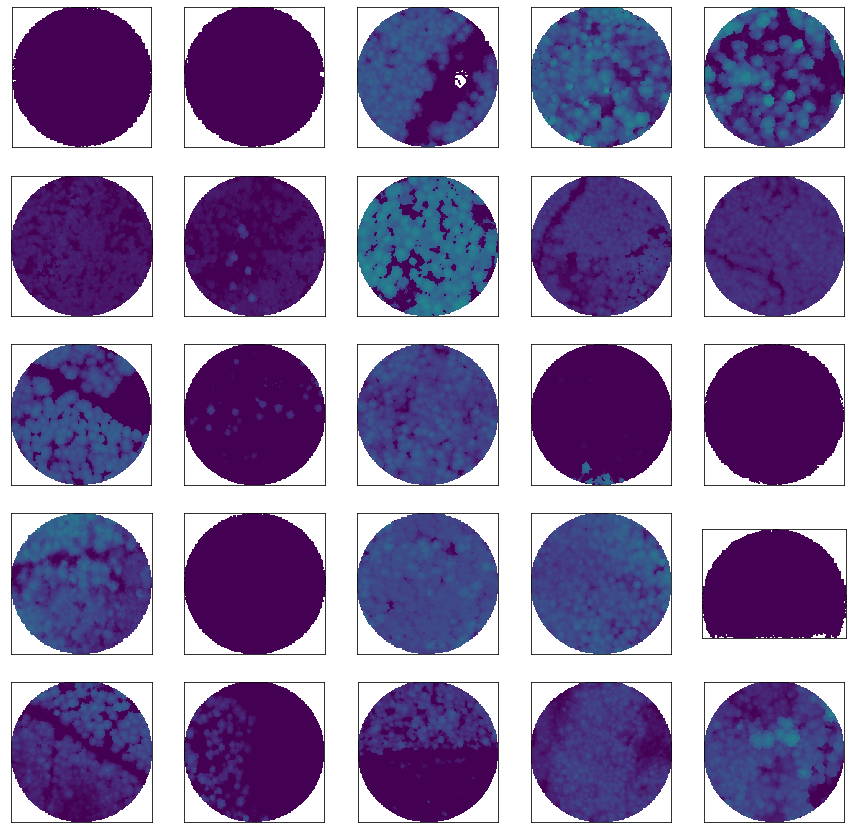

In [43]:
DNR_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/canopymodel/*.asc')
BLM_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/canopymodel/*.asc')
USFS_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/canopymodel/*.asc')
ALL_CHM = DNR_CHM + BLM_CHM + USFS_CHM
len(ALL_CHM)

fig, axs = plt.subplots(5,5, figsize=(15,15))
imgs = []
for i, r in enumerate(DNR_CHM[0:25]):
    with rasterio.open(r) as src:
        img = src.read(1, masked=True)
        imgs.append(img)
    axs.ravel()[i].imshow(img, vmin=0, vmax=122)
    axs.ravel()[i].set_xticks([])
    axs.ravel()[i].set_yticks([])

In [44]:
DNR_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/canopymodel/*.dtm')
BLM_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/canopymodel/*.dtm')
USFS_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/canopymodel/*.dtm')
ALL_CHM = DNR_CHM + BLM_CHM + USFS_CHM
len(ALL_CHM)

5135

In [45]:
res = c.persist([surface_stats(x) for x in ALL_CHM])
progress(res)

VBox()

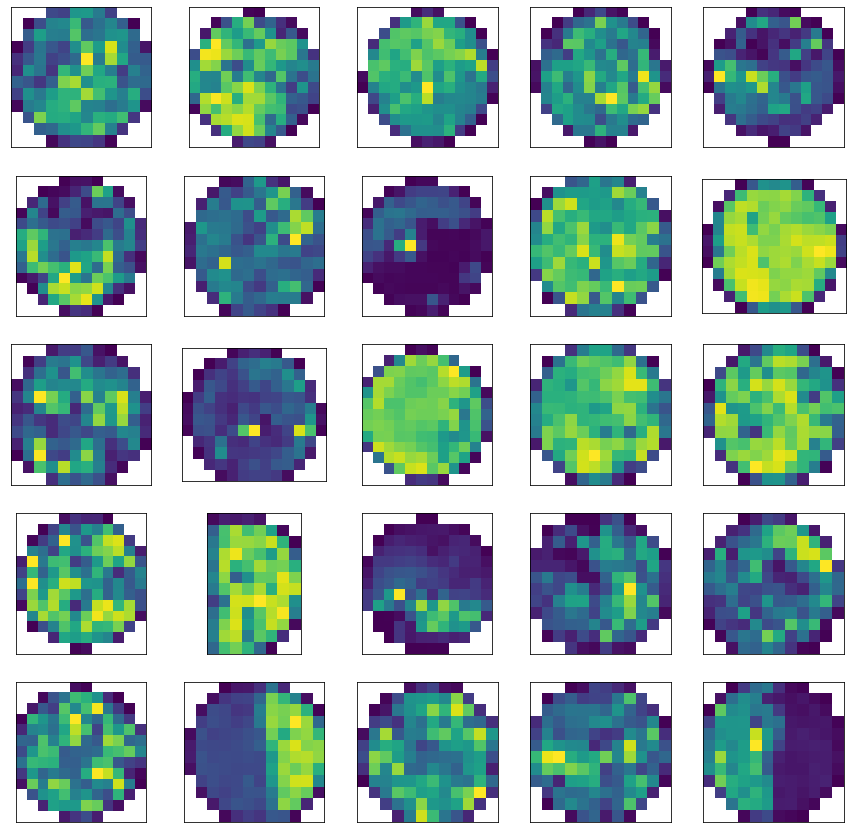

In [46]:
DNR_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/gridsurfacestats/*surface_volume.asc')
BLM_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/gridsurfacestats/*surface_volume.asc')
USFS_CHM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/gridsurfacestats/*surface_volume.asc')
ALL_CHM = DNR_CHM + BLM_CHM + USFS_CHM
len(ALL_CHM)

fig, axs = plt.subplots(5,5, figsize=(15,15))
imgs = []
for i, r in enumerate(USFS_CHM[0:25]):
    with rasterio.open(r) as src:
        img = src.read(1, masked=True)
        imgs.append(img)
    axs.ravel()[i].imshow(img)
    axs.ravel()[i].set_xticks([])
    axs.ravel()[i].set_yticks([])

## 6. Calculate TopoMetrics for each hectare-sized plot

In [47]:
@dask.delayed
def groundfilter(infile):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('processed', 'interim').replace('plot_clips', 'accepted_plot_clips').replace('hectare_clips', 'bare_ground')
    outfile = os.path.join(outdir, basename)
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/groundfilter.exe',
                           outfile,
                           '0.5',
                           infile],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
    return proc

In [48]:
DNR_HA = glob.glob('../data/processed/lidar/plot_clips/dnr_plots/hectare_clips/*.laz')
BLM_HA = glob.glob('../data/processed/lidar/plot_clips/blm_plots/hectare_clips/*.laz')
USFS_HA = glob.glob('../data/processed/lidar/plot_clips/usfs_plots/hectare_clips/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [49]:
res = c.persist([groundfilter(f) for f in ALL_HA])
progress(res)

VBox()

In [50]:
@dask.delayed
def tinsurface(infile, utm_zone):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('bare_ground', 'ground_dtm')
    outfile = os.path.join(outdir, basename.replace('.laz', '.dtm'))
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/TINSurfaceCreate.exe',
                           outfile,
                           '0.5',  # cellsize
                           'M',  # xy units
                           'M',  # z units
                           '1',  # coordsys, 1 for UTM
                           utm_zone,  # e.g., '10N'
                           '2',  # horizdatum, 2 for NAD83
                           '2',  # vertdatum, 2 for NAVD88
                           infile],
                         stderr=subprocess.PIPE,
                         stdout=subprocess.PIPE)
    return proc

In [51]:
DNR_BE = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/bare_ground/*.laz')
BLM_BE = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/bare_ground/*.laz')
USFS_BE = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/bare_ground/*.laz')
ALL_BE = DNR_BE + BLM_BE + USFS_BE
len(ALL_BE)

5135

In [52]:
res = c.persist([tinsurface(f, get_utm_location(f)[-1]) for f in ALL_BE])
progress(res)

VBox()

In [53]:
@dask.delayed
def topometrics(infile, latitude):
    dirname, basename = os.path.split(infile)
    outdir = dirname.replace('ground_dtm', 'topometrics')
    outfile = os.path.join(outdir, basename.replace('.dtm', '.csv'))
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/TopoMetrics.exe',
                           infile,
                           '10',  # cellsize
                           '20',  # topo point spacing
                           str(latitude),
                           '1',  # tpi window size
                           outfile],
                         stderr=subprocess.PIPE,
                         stdout=subprocess.PIPE)
    return proc

In [54]:
DNR_DTM = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/ground_dtm/*.dtm')
BLM_DTM = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/ground_dtm/*.dtm')
USFS_DTM = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/ground_dtm/*.dtm')
ALL_DTM = DNR_DTM + BLM_DTM + USFS_DTM
len(ALL_DTM)

5135

In [55]:
res = c.persist([topometrics(f, get_latitude(f)) for f in ALL_DTM])
progress(res)

VBox()

## 7. Extract GridSurfaceStats for each appropriately-sized plot using zonal statistics

In [56]:
def get_plot_avg(infile):
    dirname, basename = os.path.split(infile)
    shp_name = '_'.join(basename.split('_')[0:3])+'.shp'
    shp = os.path.join(dirname.replace('gridsurfacestats', 'plot_clips'),
                       shp_name)
    
    zs = zonal_stats(shp, infile, stats=['median'])
    return zs[0]['median']

In [57]:
DNR_GS = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/gridsurfacestats/*.asc')
BLM_GS = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/gridsurfacestats/*.asc')
USFS_GS = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/gridsurfacestats/*.asc')
ALL_GS = DNR_GS + BLM_GS + USFS_GS
len(ALL_GS)

35945

In [58]:
def get_gridstat(f):
    stat = '_'.join(os.path.basename(f).split('_')[3:]).split('.asc')[0]
    plot_id = '_'.join(os.path.basename(f).split('_')[:3])
    return (plot_id, stat, get_plot_avg(f))

In [59]:
res = c.map(get_gridstat, ALL_GS)
progress(res)

VBox()

In [60]:
vals = c.gather(res)

In [61]:
pivot_grid = pd.pivot(pd.DataFrame(vals, columns=['plot_id', 'gridstat', 'value']), index='plot_id', columns='gridstat', values='value').rename_axis(None, axis=1)

In [62]:
pivot_grid.to_csv('../data/processed/lidar/plot_clips/gridsurfacestats.csv')

## 8. Extract TopoMetrics for each appropriately-sized plot using zonal statistics

In [63]:
# need to execute CSV2Grid to get TopoMetrics out of CSV file and then into an ASCII raster
topo_cols_to_grid = {'Elevation (10.00 unit window)':'elevation',
                 'Slope (degrees 10.00 unit window)':'slope',
                 'Aspect (degrees azimuth 10.00 unit window)':'aspect',
                 'Profile curvature * 100 (10.00 unit window)':'profile_curvature',
                 'Plan curvature * 100 (10.00 unit window)':'plan_curvature',
                 'Solar Radiation Index (10.00 unit window)':'solar_radiation_index',
                 'Overall Curvature (10.00 unit window)':'overall_curvature'}

@dask.delayed
def batch_csv2grid(infile):
    
    dirname, basename = os.path.split(infile)

    with open(infile) as f:
        header = f.readline().strip()
        cols = header.split(',')
        topo_columns = [{'col_num': str(cols.index(col) + 1),
                         'col_name': topo_cols_to_grid[col]}
                        for col in cols if col in topo_cols_to_grid.keys()]
    procs = []
    for col in topo_columns:
        outfilename = basename.replace('topo_metrics.csv',  
                                   col['col_name']+'.asc')
        outfile = os.path.join(dirname, outfilename)
        proc = subprocess.run(['wine', '/storage/lidar/FUSION/CSV2Grid.exe',
                               infile,
                               col['col_num'],
                               outfile],
                              stderr=subprocess.PIPE,
                              stdout=subprocess.PIPE)
        procs.append(proc)
    return procs

In [64]:
DNR_CSV = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/topometrics/*_topo_metrics.csv')
BLM_CSV = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/topometrics/*_topo_metrics.csv')
USFS_CSV = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/topometrics/*_topo_metrics.csv')
ALL_CSV = DNR_CSV + BLM_CSV + USFS_CSV
len(ALL_CSV)

5135

In [65]:
res = c.persist([batch_csv2grid(f) for f in ALL_CSV])
progress(res)

VBox()

In [68]:
DNR_TOPO = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/topometrics/*.asc')
BLM_TOPO = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/topometrics/*.asc')
USFS_TOPO = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/topometrics/*.asc')
ALL_TOPO = DNR_TOPO + BLM_TOPO + USFS_TOPO
len(ALL_TOPO)

35945

In [69]:
def get_topo_avg(infile):
    dirname, basename = os.path.split(infile)
    shp_name = '_'.join(basename.split('_')[0:3])+'.shp'
    shp = os.path.join(dirname.replace('topometrics', 'plot_clips'),
                       shp_name)
    
    zs = zonal_stats(shp, infile, stats=['median'])
    return zs[0]['median']

In [70]:
def get_topometric(f):
    stat = '_'.join(os.path.basename(f).split('_')[3:]).split('.asc')[0]
    plot_id = '_'.join(os.path.basename(f).split('_')[:3])
    return (plot_id, stat, get_topo_avg(f))

In [71]:
res = c.map(get_topometric, ALL_TOPO)
progress(res)

VBox()

In [72]:
vals = c.gather(res)

In [73]:
pivot_grid = pd.pivot(
    pd.DataFrame(vals, 
                 columns=['plot_id', 'topometric', 'value']), 
    index='plot_id', 
    columns='topometric', 
    values='value').rename_axis(None, axis=1)

In [74]:
pivot_grid.to_csv('../data/processed/lidar/plot_clips/topometrics.csv')

## 9. Clip the normalized hectare plot to appropriate plot size

In [8]:
DNR_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/hectare_normalized/*.laz')
BLM_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/hectare_normalized/*.laz')
USFS_HA = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/hectare_normalized/*.laz')
ALL_HA = DNR_HA + BLM_HA + USFS_HA
len(ALL_HA)

5135

In [9]:
res = c.persist([clip_smaller_plots(x) for x in ALL_HA])
progress(res)

VBox()

## 10. Execute CloudMetrics for the normalized plot-sized clip

In [10]:
@dask.delayed
def make_cloudmetrics(infile):
    dirname, basename = os.path.split(infile)
    
    # look in ../data/interim/lidar/plot_clips/..._plots/hectare_normalized/
    # write to ../data/processed/lidar/plot_clips/..._plots/cloudmetrics
    outdir = dirname.replace('plot_normalized', 'cloudmetrics')
    outfile = os.path.join(outdir, basename.replace('.laz', '.csv'))
    
    proc = subprocess.run(['wine', '/storage/lidar/FUSION/cloudmetrics.exe',
                           '/above:1.37',
                           '/strata:0.15, 1.37, 5.0, 10.0, 20.0, 30.0',
                           '/intstrata:0.15, 1.37, 5.0, 10.0, 20.0, 30.0',
                           infile,
                           outfile],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
                
    return proc

In [11]:
DNR_PLOTS = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/plot_normalized/*.laz')
BLM_PLOTS = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/plot_normalized/*.laz')
USFS_PLOTS = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/plot_normalized/*.laz')
ALL_PLOTS = DNR_PLOTS + BLM_PLOTS + USFS_PLOTS
len(ALL_PLOTS)

5135

In [12]:
res = c.persist([make_cloudmetrics(x) for x in ALL_PLOTS])
progress(res)

VBox()

## 11. Consolidate CloudMetrics into a text files

In [13]:
DNR_CSVS = glob.glob('../data/interim/lidar/accepted_plot_clips/dnr_plots/cloudmetrics/*.csv')
BLM_CSVS = glob.glob('../data/interim/lidar/accepted_plot_clips/blm_plots/cloudmetrics/*.csv')
USFS_CSVS = glob.glob('../data/interim/lidar/accepted_plot_clips/usfs_plots/cloudmetrics/*.csv')
len(DNR_CSVS), len(BLM_CSVS), len(USFS_CSVS)

(3110, 1398, 627)

In [14]:
dnr_cloudmetrics = pd.concat([pd.read_csv(csv) for csv in DNR_CSVS],
                             axis=0, ignore_index=True)

In [15]:
blm_cloudmetrics = pd.concat([pd.read_csv(csv) for csv in BLM_CSVS],
                             axis=0, ignore_index=True)

In [16]:
usfs_cloudmetrics = pd.concat([pd.read_csv(csv) for csv in USFS_CSVS],
                             axis=0, ignore_index=True)

In [17]:
dnr_cloudmetrics.to_csv('../data/processed/lidar/plot_clips/dnr_plots/cloudmetrics.csv',
                       index=False)
blm_cloudmetrics.to_csv('../data/processed/lidar/plot_clips/blm_plots/cloudmetrics.csv',
                       index=False)
usfs_cloudmetrics.to_csv('../data/processed/lidar/plot_clips/usfs_plots/cloudmetrics.csv',
                        index=False)

In [18]:
all_cloudmetrics = pd.concat([dnr_cloudmetrics, blm_cloudmetrics, usfs_cloudmetrics],
                             axis=0, ignore_index=True)

In [19]:
all_cloudmetrics.to_csv('../data/processed/lidar/plot_clips/cloudmetrics.csv',
                       index=False)

In [20]:
# c.close()
# cluster.close()